In [1]:
import numpy as np
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)


from matplotlib import pyplot as plt

import numpy as np
from matplotlib.pyplot import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import math
import itertools

In [6]:
two = tf.constant(2., dtype='float32', shape=(100,))
pi = tf.constant(np.pi, dtype='float32', shape=(100,))
def A_fun(x, y):
    A = two*y*tf.sin(pi*x)
    return tf.reshape(A, shape=(100, 1))
grid = np.array([[x,y] for y in np.linspace(0,1,10) for x in np.linspace(0,1,10)])
train_set = tf.constant(grid,dtype='float32') 

In [9]:
class Trial(tf.keras.layers.Layer):
    one = tf.constant(1., dtype='float32')
    def __init__(self):
        super().__init__()
        self.hidden = tf.keras.layers.Dense(
            units=10, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(
            units=1, activation='linear')
    def call(self, inputs):
        net_out = self.hidden(inputs)
        net_out = self.out(net_out)
        X1 = tf.concat([tf.reshape(inputs[:,0], shape=(100, 1)),
                      tf.constant(1.0, dtype='float32', shape=(100, 1))], axis=1)
        with tf.GradientTape() as tape:
            tape.watch(X1)
            net_1 = self.hidden(X1)
            net_1 = self.out(net_1)
        dnet_1 = tape.gradient(net_1, X1)
        dnet_1 = tf.reshape(dnet_1[:,1], shape=(100, 1))
        x = tf.reshape(inputs[:,0], shape=(100, 1))
        y = tf.reshape(inputs[:,1], shape=(100, 1))
        one = tf.constant(1., dtype='float32', shape=(100,1))
        net_out -= net_1
        net_out -= dnet_1
        net_out *= x*(one-x)*y
        net_out += A_fun(inputs[:,0], inputs[:,1])
        return net_out

In [22]:
inp = tf.keras.layers.Input(name='inputs',shape=(2),dtype=tf.dtypes.float32)
trial_sol = Trial()
model = tf.keras.Sequential([inp, trial_sol])

Adam = tf.keras.optimizers.Adam(5e-3)
SGD = tf.keras.optimizers.SGD(5e-3)
epochs = 100000

Text(0.5, 0.98, 'Obliczanie RRCz')

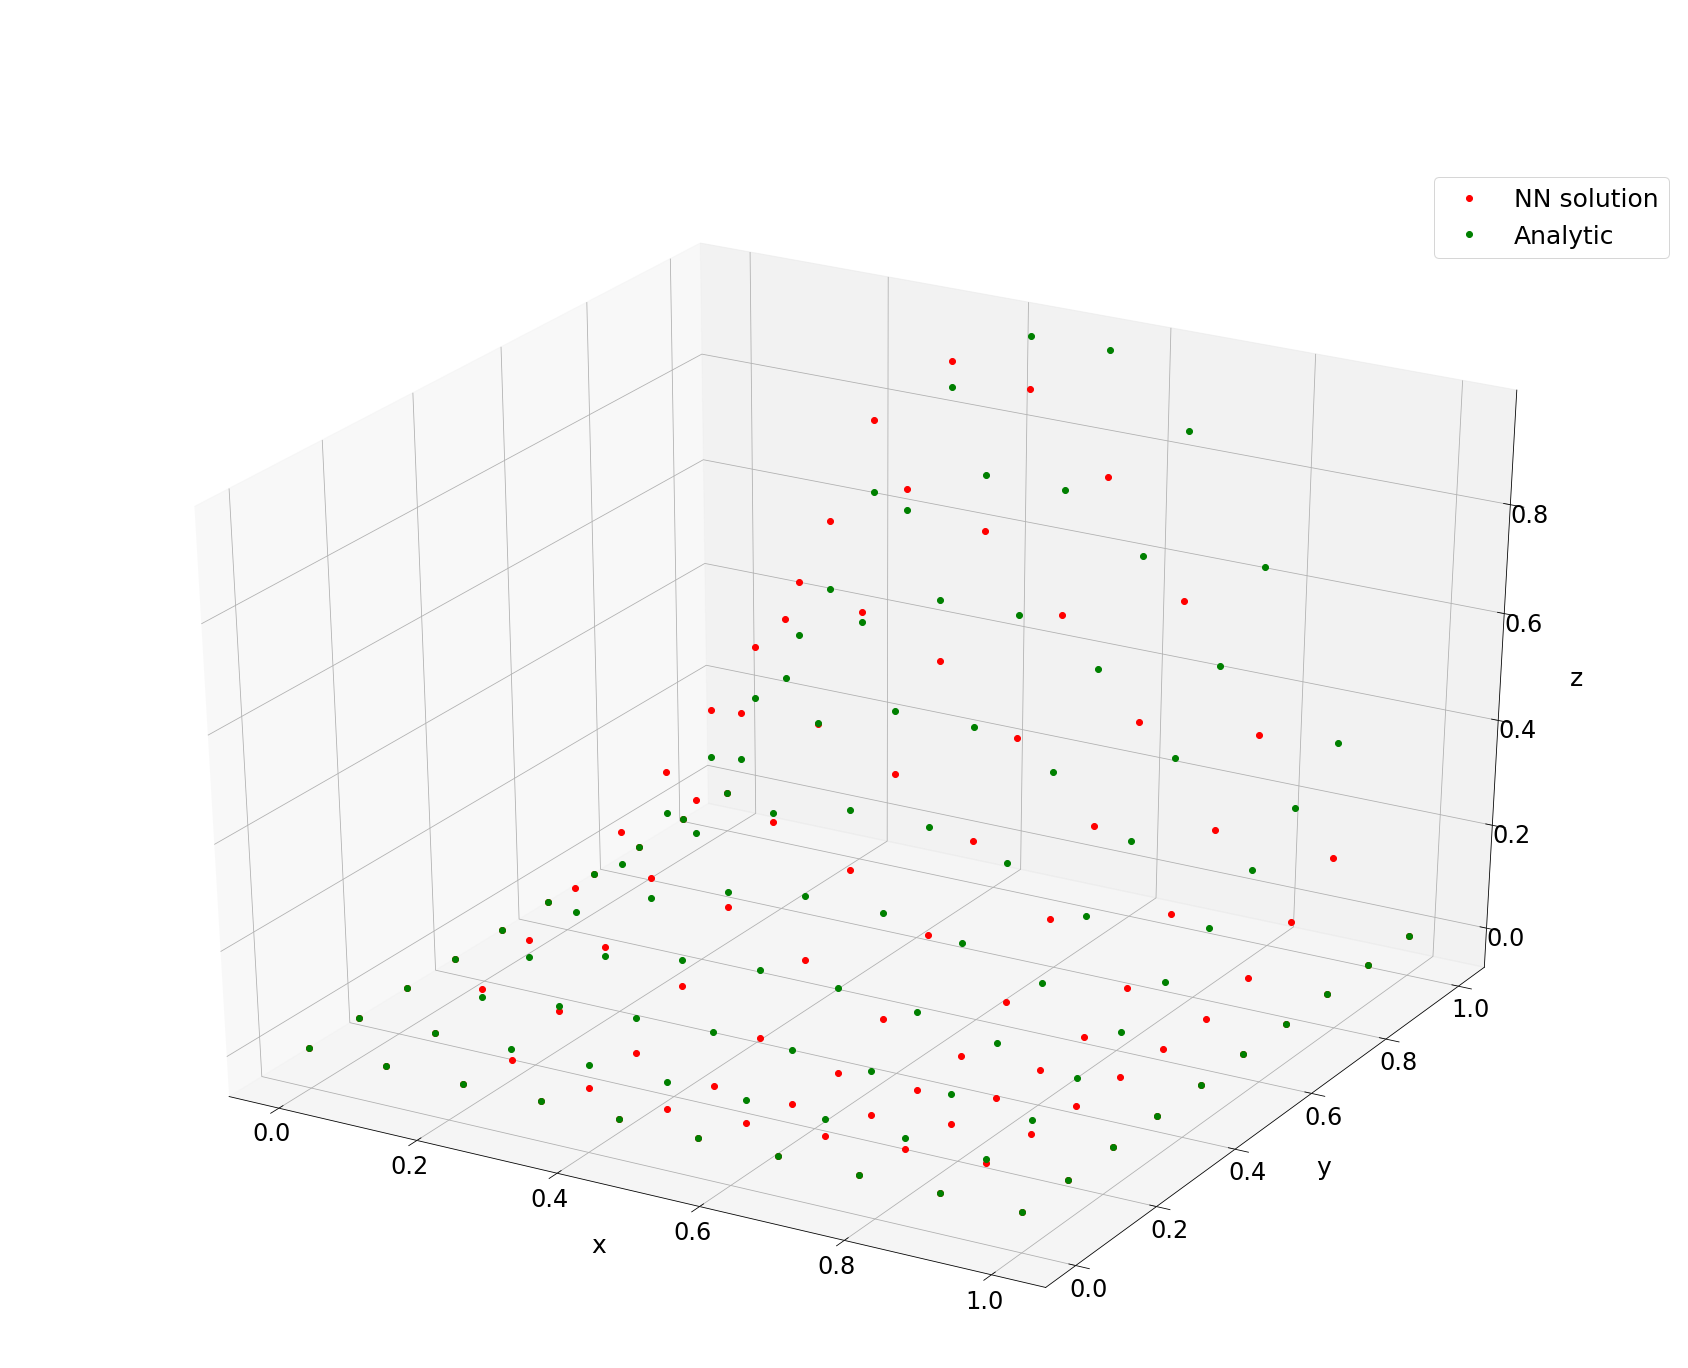

In [27]:
#e = math.exp(-1)
#A = (1-x)*y**3 + x*(1+y**3)*e + (1-y)*x*(tf.math.exp(-x) - e) + y*((1+x)*tf.math.exp(-x) - (1 - x-2*x*e))

xx = tf.gather(train_set, [0], axis=1)
yy = tf.gather(train_set, [1], axis=1)
fig, ax = plt.subplots(figsize=(30,22),subplot_kw={'projection': '3d'})
nx = tf.reshape(xx, -1)
ny = tf.reshape(yy, -1)
#ax.plot(nx,ny,tf.reshape(A, -1), 'ro', label='A[x,y] solution')
#ax.plot(nx,ny,tf.reshape(A, -1) + nx*(1-nx)*ny*(1-ny)*tf.reshape(f1, -1), 'bo', label='XD solution')

ax.plot(nx,ny,tf.reshape(model(train_set), -1), 'ro', label='NN solution')
ax.plot(nx,ny, ny**2*tf.sin(pi*nx), 'go', label='Analytic')
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel('x',fontsize = 25, labelpad=25)
ax.set_zlabel('z',fontsize = 25, labelpad=25)
ax.set_ylabel('y',fontsize = 25, labelpad=25)
ax.legend(fontsize=25)
#ax.view_init(0, 20)
fig.suptitle('Obliczanie RRCz', fontsize=40, color='white')

In [25]:
def custom_loss(network, inputs):
    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape:
            inputs = tf.convert_to_tensor(inputs)
            tape.watch(inputs)
            tape2.watch(inputs)
            response = network(inputs)  
        grads = tape.gradient(response, inputs)
    laplace = tape2.gradient(grads, inputs)
#   print(grads)
#   print(laplace)
    two = tf.constant(2, dtype='float32')
    pi = tf.constant(np.pi, dtype='float32')
    loss = tf.square(laplace[:,0] + laplace[:,1] + response * grads[:,1]
                   - tf.sin(pi*inputs[:,0])*(two  - pi**2*inputs[:,1]**2 + two * inputs[:,1]**3*tf.sin(pi*inputs[:,0])))
    return tf.reduce_mean(loss)

In [26]:
@tf.function
def train_step(mod, X):
    with tf.GradientTape() as tape:
        tape.watch(X)
        t_loss = custom_loss(mod, X)
    gradients = tape.gradient(t_loss, mod.trainable_variables)
    Adam.apply_gradients(zip(gradients, mod.trainable_variables))

    return t_loss
for step in range(epochs):
#    for x_tensor in train_set:
#        x = tf.reshape(x_tensor, shape=(1, 2))
    t1 = train_step(model, train_set)
    if step % 500 == 0:
        print(f"Training loss {step} {t1}")


Training loss 0 123.44892120361328
Training loss 500 7.719778060913086
Training loss 1000 4.475049018859863
Training loss 1500 2.2777116298675537
Training loss 2000 1.7242470979690552
Training loss 2500 1.3626700639724731
Training loss 3000 1.1722480058670044
Training loss 3500 1.0641088485717773
Training loss 4000 0.9575322270393372
Training loss 4500 0.8340908885002136
Training loss 5000 0.7168915271759033
Training loss 5500 0.6288056373596191
Training loss 6000 0.5725038647651672
Training loss 6500 0.5363919138908386
Training loss 7000 0.4910009801387787
Training loss 7500 0.44205474853515625
Training loss 8000 0.40395790338516235
Training loss 8500 0.3752528727054596
Training loss 9000 0.35818803310394287
Training loss 9500 0.35066357254981995
Training loss 10000 0.3460845351219177
Training loss 10500 0.3432408571243286
Training loss 11000 0.34066811203956604
Training loss 11500 0.3376023471355438
Training loss 12000 0.3327736258506775
Training loss 12500 0.32247328758239746
Traini

KeyboardInterrupt: 

In [28]:
diff = ny**2*tf.sin(pi*nx) - tf.reshape(model(train_set), -1)

In [31]:
np.abs(diff).mean()

0.08919693